In [1]:
# 強化学習環境の標準ライブラリ
!pip install gymnasium
# ゲーム画面のレンダリング及び演算に使用するライブラリ
!pip install pygame numpy

In [2]:
import numpy as np
import pandas as pd
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CallbackList

class TrainingRewardLogger(BaseCallback):
    """
    エピソードが終了するたびに（現在のtimesteps、episode_reward）を記録。
    Monitorラッパーがinfo['episode']を挿入してくれるので、それを活用。
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.t = []
        self.rew = []

    def _on_step(self) -> bool:
        # VecEnv基準でinfosはリスト。done時に'episode'キーが含まれる。
        infos = self.locals.get("infos", None)
        if infos:
            for info in infos:
                ep = info.get("episode")
                if ep is not None:  # エピソード終了時点
                    self.t.append(self.num_timesteps)
                    self.rew.append(ep["r"])
        return True

class EvalWithAccuracy(EvalCallback):
    """
    基本的なEvalCallbackを拡張し、「eval/accuracy_pct」をTensorBoardに記録し、
    (timesteps, accuracy_pct) をhistoryとして保管。
    正解率 = 各エピソードの (game_score / max_score)*100 の平均。
    """
    def __init__(self, eval_env, *args, n_eval_episodes=5, **kwargs):
        super().__init__(eval_env, *args, n_eval_episodes=n_eval_episodes, **kwargs)
        self.eval_steps = []
        self.eval_acc = []

    def _on_step(self) -> bool:
        result = super()._on_step()

        if self.eval_freq > 0 and (self.n_calls % self.eval_freq == 0):
            acc_list = []
            for _ in range(self.n_eval_episodes):
                # Gymnasium/VecEnvのresetと互換
                try:
                    obs, _ = self.eval_env.reset()
                except Exception:
                    obs = self.eval_env.reset()

                dones = np.array([False])
                while not dones[0]:
                    action, _ = self.model.predict(obs, deterministic=True)
                    obs, rewards, dones, infos = self.eval_env.step(action)

                info = infos[0] if isinstance(infos, (list, tuple)) else infos
                gs = info.get("game_score", None)
                ms = info.get("max_score", None)
                if gs is not None and ms and ms > 0:
                    acc_list.append(100.0 * float(gs) / float(ms))

            if acc_list:
                mean_acc = float(np.mean(acc_list))
                # TensorBoardに記録
                self.logger.record("eval/accuracy_pct", mean_acc)
                # 内部記録（グラフ用）
                self.eval_steps.append(self.n_calls)  # または self.num_timesteps
                self.eval_acc.append(mean_acc)
        return result

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [3]:
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np

class RhythmGameEnv(gym.Env):
    """
    強化学習エージェントのためのリズムゲーム環境（Gymnasium標準）。
    - 行動: 0～3 レーンを叩く、4は無入力
    - 観測: (H, W, 1) グレースケール画像(uint8)
    """
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 30}

    def __init__(self, density: str = "medium", render_mode: str | None = None):
        super().__init__()
        # ---- 環境パラメータ ----
        self.render_mode = render_mode
        self.density = density
        self.screen_width, self.screen_height = 300, 400
        self.num_lanes = 4
        self.note_width, self.note_height = 50, 20
        self.note_speed = 5                  # px/frame
        self.max_frames = 500                # エピソードの長さ（フレーム）
        self.judgment_line_y = self.screen_height - 50

        # 判定範囲/報酬
        self.judgments = {
            "perfect": {"range": 5,  "reward": 100},
            "good":    {"range": 12, "reward": 60},
            "ok":      {"range": 20, "reward": 40},
        }
        self.miss_penalty = -50              # ノーツを見逃した場合のペナルティ
        self.wrong_input_penalty = -5        # 判定ゾーンにノーツがないのに叩いた場合

        # 密度（フレーム間の最小間隔）
        self.density_settings = {"low": 15, "medium": 10, "high": 5}
        self.min_spacing_frames = self.density_settings[self.density]

        # ---- Gym空間 ----
        self.action_space = spaces.Discrete(self.num_lanes + 1)  # 0..3: 打鍵, 4: 無入力
        self.observation_space = spaces.Box(
            low=0, high=255, shape=(self.screen_height, self.screen_width, 1), dtype=np.uint8
        )

        # ---- レンダリング初期化 ----
        self.screen = None
        self.clock = None
        if self.render_mode == "human":
            pygame.init()
            pygame.display.set_caption("Rhythm Game RL Environment")
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()

        # ランタイム状態（resetで初期化）
        self.notes = []
        self.current_frame = 0
        self.total_reward = 0
        self.total_notes = 0
        self.hits = 0
        self.misses = 0
        self.max_score = 0

    # ---------- ユーティリティ ----------
    def _generate_notes(self):
        """シードの一貫性のためにself.np_randomを使用。"""
        notes = []
        for frame in range(0, self.max_frames, self.min_spacing_frames):
            if self.np_random.random() < 0.7:  # 70%の確率でノーツを生成
                lane = int(self.np_random.integers(0, self.num_lanes))
                # 開始位置は画面の上部外側（フレームの進行に伴い下に移動）
                y0 = -self.note_height / 2 - frame * self.note_speed
                notes.append([lane, y0])
        return notes

    def _calculate_max_score(self):
        """全てのノーツをperfectで叩いた場合の理論上の最高スコア。"""
        return len(self.notes) * self.judgments["perfect"]["reward"]

    def _draw_surface(self):
        surface = pygame.Surface((self.screen_width, self.screen_height))
        surface.fill((255, 255, 255))
        lane_w = self.screen_width / self.num_lanes
        for i in range(1, self.num_lanes):
            pygame.draw.line(surface, (200, 200, 200),
                             (i * lane_w, 0), (i * lane_w, self.screen_height), 1)
        for lane, y in self.notes:
            if 0 <= y <= self.screen_height:
                x = (lane + 0.5) * lane_w
                rect = pygame.Rect(x - self.note_width / 2, y - self.note_height / 2,
                                  self.note_width, self.note_height)
                pygame.draw.rect(surface, (0, 0, 0), rect)
        # 判定ライン（レンダリング時にのみ表示）
        pygame.draw.line(surface, (255, 0, 0), (0, self.judgment_line_y),
                         (self.screen_width, self.judgment_line_y), 2)
        return surface

    def _get_obs(self):
        surface = pygame.Surface((self.screen_width, self.screen_height))
        surface.fill((255, 255, 255))
        lane_w = self.screen_width / self.num_lanes
        for i in range(1, self.num_lanes):
            pygame.draw.line(surface, (200, 200, 200),
                             (i * lane_w, 0), (i * lane_w, self.screen_height), 1)
        for lane, y in self.notes:
            if 0 <= y <= self.screen_height:
                x = (lane + 0.5) * lane_w
                rect = pygame.Rect(x - self.note_width / 2, y - self.note_height / 2,
                                  self.note_width, self.note_height)
                pygame.draw.rect(surface, (0, 0, 0), rect)

        rgb = pygame.surfarray.array3d(surface)      # (W,H,3)
        rgb = np.transpose(rgb, (1, 0, 2))           # (H,W,3)
        gray = rgb.mean(axis=2, keepdims=True)       # float
        return gray.astype(np.uint8)                 # (H,W,1)

    def _get_info(self):
        hit_rate = (self.hits / self.total_notes) if self.total_notes > 0 else 0.0
        return {
            "total_reward": self.total_reward,
            "game_score": self.total_reward,   # 報酬と同じ値を使用（必要に応じて分離可能）
            "max_score": self.max_score,
            "hits": self.hits,
            "misses": self.misses,
            "hit_rate": hit_rate,
            "notes_left": len(self.notes),
        }

    # ---------- Gym API ----------
    def reset(self, seed: int | None = None, options=None):
        super().reset(seed=seed)
        self.current_frame = 0
        self.notes = self._generate_notes()
        self.total_notes = len(self.notes)
        self.hits = 0
        self.misses = 0
        self.total_reward = 0
        self.max_score = self._calculate_max_score()
        obs = self._get_obs()
        info = self._get_info()
        return obs, info

    def step(self, action: int):
        # 1) ノーツの移動
        for n in self.notes:
            n[1] += self.note_speed

        # 2) 入力処理（1フレームあたり最大1つのノーツのみヒット可能）
        reward = 0.0
        processed = False
        action_taken = (action < self.num_lanes)

        for note in self.notes[:]:
            lane, y = note
            diff = abs(y - self.judgment_line_y)
            if diff <= self.judgments["perfect"]["range"]:
                if action_taken and action == lane:
                    reward += self.judgments["perfect"]["reward"]
                    self.hits += 1
                    self.notes.remove(note)
                processed = True
                break
            elif diff <= self.judgments["good"]["range"]:
                if action_taken and action == lane:
                    reward += self.judgments["good"]["reward"]
                    self.hits += 1
                    self.notes.remove(note)
                processed = True
                break
            elif diff <= self.judgments["ok"]["range"]:
                if action_taken and action == lane:
                    reward += self.judgments["ok"]["reward"]
                    self.hits += 1
                    self.notes.remove(note)
                processed = True
                break

        # 3) 誤入力ペナルティ
        if action_taken and not processed:
            reward += self.wrong_input_penalty

        # 4) 見逃しノーツ（判定ラインを通過）のペナルティ
        missed = [n for n in self.notes if n[1] > self.judgment_line_y + self.judgments["ok"]["range"]]
        if missed:
            self.misses += len(missed)
            reward += self.miss_penalty * len(missed)
            self.notes = [n for n in self.notes if n not in missed]

        self.total_reward += reward
        self.current_frame += 1

        # 5) 終了判定
        terminated = (len(self.notes) == 0) or (self.current_frame >= self.max_frames)
        truncated = False  # 時間制限などで打ち切る必要がなければFalse

        obs = self._get_obs()
        info = self._get_info()

        # 6) レンダリング
        if self.render_mode == "human":
            # humanモードでは実際の画面も更新
            surf = self._draw_surface()
            self.screen.blit(surf, (0, 0))
            pygame.event.pump()
            pygame.display.flip()
            if self.clock is not None:
                self.clock.tick(self.metadata["render_fps"])

        return obs, reward, terminated, truncated, info

    def render(self):
        if self.render_mode == "rgb_array":
            # 判定ラインを含むフレームを返す
            surf = self._draw_surface()
            rgb = pygame.surfarray.array3d(surf)
            rgb = np.transpose(rgb, (1, 0, 2))
            return rgb
        elif self.render_mode == "human":
            # step()で既に更新済み
            return None

    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
            self.clock = None

In [4]:
# --- 環境がGymnasium標準に準拠しているか確認 ---
from gymnasium.utils.env_checker import check_env

try:
    # レンダリングなしでチェックする方が高速です。
    env_check = RhythmGameEnv(density='medium', render_mode=None)
    check_env(env_check)
    print("✅ Gymnasium環境標準チェックに合格しました！")
except Exception as e:
    print(f"❌ 環境標準チェックに失敗しました: {e}")


# --- ランダムエージェントによるゲームプレイの可視化（改善版） ---
# render_modeを'human'に設定してゲームウィンドウを表示します。
env = RhythmGameEnv(density='high', render_mode='human')
# seedを設定して、常に同じノーツパターンでテストできるようにします。
observation, info = env.reset(seed=42)

print("\n--- ランダムエージェントのテスト開始 ---")
print("エピソードが1回終了するまでゲームを実行します。Pygameウィンドウを確認してください。")

done = False
truncated = False
total_reward = 0
frame_count = 0

while not done and not truncated:
    action = env.action_space.sample()  # ランダムな行動を選択
    observation, reward, done, truncated, info = env.step(action)
    total_reward += reward
    frame_count += 1
    
    # 報酬が発生した時のみログを出力し、可読性を向上
    score = info.get('game_score', info.get('total_reward', 0.0))

    if reward != 0:
        print(f"フレーム: {frame_count}, 行動: {action}, 報酬: {reward:.1f}, 現在の合計スコア: {score:.1f}")
        
print("\n--- エピソード終了 ---")
print(f"合計フレーム: {frame_count}")
print(f"最終スコア: {score:.1f}")

env.close() # テスト終了後にウィンドウを閉じる
print("--- テスト終了 ---")

c:\venv_for_ipynb\venv_python_3.11\Lib\site-packages\gymnasium\utils\env_checker.py:434: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantiating the environment through `gymnasium.make`
  logger.warn(


✅ Gymnasium環境標準チェックに合格しました！

--- ランダムエージェントのテスト開始 ---
エピソードが1回終了するまでゲームを実行します。Pygameウィンドウを確認してください。
フレーム: 1, 行動: 2, 報酬: -5.0, 現在の合計スコア: -5.0
フレーム: 2, 行動: 1, 報酬: -5.0, 現在の合計スコア: -10.0
フレーム: 3, 行動: 1, 報酬: -5.0, 現在の合計スコア: -15.0
フレーム: 4, 行動: 1, 報酬: -5.0, 現在の合計スコア: -20.0
フレーム: 6, 行動: 3, 報酬: -5.0, 現在の合計スコア: -25.0
フレーム: 7, 行動: 0, 報酬: -5.0, 現在の合計スコア: -30.0
フレーム: 8, 行動: 2, 報酬: -5.0, 現在の合計スコア: -35.0
フレーム: 9, 行動: 0, 報酬: -5.0, 現在の合計スコア: -40.0
フレーム: 10, 行動: 3, 報酬: -5.0, 現在の合計スコア: -45.0
フレーム: 11, 行動: 2, 報酬: -5.0, 現在の合計スコア: -50.0
フレーム: 12, 行動: 2, 報酬: -5.0, 現在の合計スコア: -55.0
フレーム: 13, 行動: 3, 報酬: -5.0, 現在の合計スコア: -60.0
フレーム: 14, 行動: 3, 報酬: -5.0, 現在の合計スコア: -65.0
フレーム: 15, 行動: 1, 報酬: -5.0, 現在の合計スコア: -70.0
フレーム: 16, 行動: 0, 報酬: -5.0, 現在の合計スコア: -75.0
フレーム: 17, 行動: 0, 報酬: -5.0, 現在の合計スコア: -80.0
フレーム: 18, 行動: 1, 報酬: -5.0, 現在の合計スコア: -85.0
フレーム: 19, 行動: 0, 報酬: -5.0, 現在の合計スコア: -90.0
フレーム: 20, 行動: 0, 報酬: -5.0, 現在の合計スコア: -95.0
フレーム: 21, 行動: 0, 報酬: -5.0, 現在の合計スコア: -100.0
フレーム: 22, 行動: 0, 報酬: -5.0, 現在の合計スコア: -105.0
フレーム

## 학습화면 가시화

## 학습화면 예시

--- PPO モデルの学習開始 (n_envs=16, n_steps=2048, batch_size=4096, Timesteps=3500000) ---


c:\venv_for_ipynb\venv_python_3.11\Lib\site-packages\stable_baselines3\common\callbacks.py:418: UserWarning: Training and eval env are not of the same type<stable_baselines3.common.vec_env.vec_transpose.VecTransposeImage object at 0x000001A8E80F2450> != <stable_baselines3.common.vec_env.vec_frame_stack.VecFrameStack object at 0x000001A8E942D1D0>
  warnings.warn("Training and eval env are not of the same type" f"{self.training_env} != {self.eval_env}")


Eval num_timesteps=32768, episode_reward=2041.00 +/- 2909.66
Episode length: 545.80 +/- 22.40
New best mean reward!
Eval num_timesteps=65536, episode_reward=8432.00 +/- 3932.92
Episode length: 551.60 +/- 4.41
New best mean reward!
Eval num_timesteps=98304, episode_reward=2114.00 +/- 3851.60
Episode length: 532.80 +/- 26.17
Eval num_timesteps=131072, episode_reward=2161.00 +/- 2877.65
Episode length: 523.40 +/- 27.43
Eval num_timesteps=163840, episode_reward=2035.00 +/- 1579.20
Episode length: 545.80 +/- 22.40
Eval num_timesteps=196608, episode_reward=437.00 +/- 1640.13
Episode length: 545.80 +/- 22.40
Eval num_timesteps=229376, episode_reward=3749.00 +/- 4110.70
Episode length: 523.40 +/- 27.43
Eval num_timesteps=262144, episode_reward=2158.00 +/- 1658.18
Episode length: 521.60 +/- 25.39
Eval num_timesteps=294912, episode_reward=2962.00 +/- 4849.60
Episode length: 523.40 +/- 27.43
Eval num_timesteps=327680, episode_reward=2969.00 +/- 4137.25
Episode length: 521.60 +/- 25.39
Eval num_ti

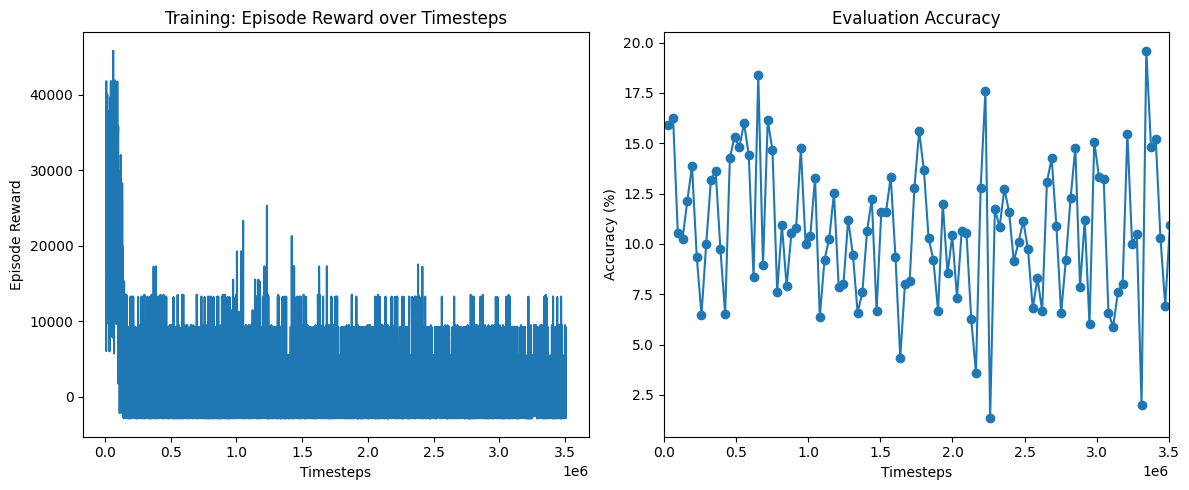


--- TensorBoardで学習過程を確認する方法 ---
%load_ext tensorboard
%tensorboard --logdir logs

--- 最高性能モデルのプレイ動画録画開始 ---
最高性能モデルの読み込み成功: models\best_model_PPO_high\best_model.zip
--- 動画録画終了 ---
最高性能エージェントの最終スコア: 12000 / 60000 (20.00%)
プレイ動画を'agent_play_PPO_high.mp4'ファイルとして保存します...


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (300, 400) to (304, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


保存完了。


In [5]:
# --- 0. ライブラリのインストール ---
# !pip install gymnasium pygame numpy "stable-baselines3[extra]" tensorboard imageio imageio-ffmpeg

# --- 1. ライブラリのインポート ---
import os
import gymnasium as gym
from gymnasium import spaces
import pygame
import numpy as np
import imageio
from IPython.display import Video, display

from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, SubprocVecEnv
from gymnasium.wrappers import ResizeObservation, ReshapeObservation

import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback, CallbackList, EvalCallback
import torch

# GPU最適化設定
torch.backends.cudnn.benchmark = True

# --- 2. 強化学習ゲーム環境クラスの定義 ---
class RhythmGameEnv(gym.Env):
    """
    強化学習エージェントのための動的リズムゲーム環境。
    RL報酬と実際のゲームスコアを分離して計算します。
    """
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 30}

    def __init__(self, density='medium', render_mode=None):
        super().__init__()
        self.density = density
        self.render_mode = render_mode
        self.screen_width, self.screen_height = 300, 400
        self.num_lanes = 4
        self.note_width, self.note_height, self.note_speed = 50, 20, 5
        self.judgment_line_y = self.screen_height - 50
        
        self.judgments = {
            'perfect': {'range': 5,  'reward': 10000},
            'good':    {'range': 10, 'reward': 6000},
            'ok':      {'range': 20, 'reward': 4000},
        }
        self.miss_penalty = -10
        self.wrong_input_penalty = -5

        self.density_settings = {'low': 200, 'medium': 150, 'high': 80}
        self.min_spacing_frames = self.density_settings[self.density]
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.screen_height, self.screen_width, 1), dtype=np.uint8)
        
        self.screen = None
        self.clock = None
        if self.render_mode == "human":
            pygame.init()
            pygame.display.set_caption("Rhythm Game RL Environment")
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()

    def _generate_notes(self):
        notes = []
        for frame in range(0, 500, self.min_spacing_frames):
            if self.np_random.random() < 0.7:
                lane = self.np_random.integers(0, self.num_lanes)
                notes.append([lane, -self.note_height / 2 - frame * self.note_speed])
        return notes

    def _calculate_max_score(self):
        return len(self.notes) * self.judgments['perfect']['reward']

    def _get_obs(self):
        surface = pygame.Surface((self.screen_width, self.screen_height))
        surface.fill((255, 255, 255))
        lane_width = self.screen_width / self.num_lanes
        for i in range(1, self.num_lanes):
            pygame.draw.line(surface, (200, 200, 200), (i * lane_width, 0), (i * lane_width, self.screen_height), 1)
        for note in self.notes:
            lane, y_pos = note
            if 0 <= y_pos <= self.screen_height:
                x_pos = (lane + 0.5) * lane_width
                rect = pygame.Rect(x_pos - self.note_width / 2, y_pos - self.note_height / 2, self.note_width, self.note_height)
                pygame.draw.rect(surface, (0, 0, 0), rect)
        obs = pygame.surfarray.array3d(surface)
        obs = np.transpose(obs, (1, 0, 2))
        return np.mean(obs, axis=2, keepdims=True, dtype=np.uint8)

    def _get_info(self):
        return {
            "rl_score": self.total_rl_score, 
            "game_score": self.total_game_score,
            "max_score": self.max_score
        }

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.notes = self._generate_notes()
        self.max_score = self._calculate_max_score()
        self.total_rl_score = 0
        self.total_game_score = 0
        self.current_frame = 0
        return self._get_obs(), self._get_info()

    def step(self, action):
        rl_reward = 0
        game_score_delta = 0
        done = False
        
        for note in self.notes: 
            note[1] += self.note_speed
        action_taken = action < self.num_lanes
        note_processed = False
        
        for note in self.notes[:]:
            lane, y_pos = note
            diff = abs(y_pos - self.judgment_line_y)
            if diff <= self.judgments['ok']['range']:
                if action_taken and action == lane:
                    if diff <= self.judgments['perfect']['range']:
                        score = self.judgments['perfect']['reward']
                    elif diff <= self.judgments['good']['range']:
                        score = self.judgments['good']['reward']
                    else:
                        score = self.judgments['ok']['reward']
                    
                    rl_reward += score
                    game_score_delta += score
                    self.notes.remove(note)
                    note_processed = True
                    break

        if action_taken and not note_processed:
            rl_reward += self.wrong_input_penalty

        removed_notes = [n for n in self.notes if n[1] > self.judgment_line_y + self.judgments['ok']['range']]
        if removed_notes:
            rl_reward += self.miss_penalty * len(removed_notes)
            self.notes = [n for n in self.notes if n not in removed_notes]

        self.total_rl_score += rl_reward
        self.total_game_score += game_score_delta
        self.current_frame += 1
        
        if not self.notes and self.current_frame > 500:
            done = True
            
        return self._get_obs(), rl_reward, done, False, self._get_info()
    
    def render(self):
        obs = self._get_obs()
        obs_rgb = np.repeat(obs, 3, axis=2)
        surface = pygame.surfarray.make_surface(np.transpose(obs_rgb, (1, 0, 2)))
        pygame.draw.line(surface, (255, 0, 0), (0, self.judgment_line_y), (self.screen_width, self.judgment_line_y), 2)
        if self.render_mode == "human":
            if self.screen is None:
                pygame.init()
                self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.screen.blit(surface, (0, 0))
            pygame.event.pump()
            pygame.display.flip()
            if self.clock is None:
                self.clock = pygame.time.Clock()
            self.clock.tick(self.metadata["render_fps"])
            return None
        elif self.render_mode == "rgb_array":
            return np.transpose(pygame.surfarray.array3d(surface), (1, 0, 2))
            
    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None

# --- 2種類のコールバックを定義 ---
class TrainingRewardLogger(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.t, self.rew = [], []

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", None)
        if infos:
            for info in infos:
                ep = info.get("episode")
                if ep is not None:
                    self.t.append(self.num_timesteps)
                    self.rew.append(ep["r"])
        return True

EVAL_SEED_BASE = 2025

class EvalWithAccuracy(EvalCallback):
    def __init__(self, eval_env, *args, n_eval_episodes=5, **kwargs):
        super().__init__(eval_env, *args, n_eval_episodes=n_eval_episodes, **kwargs)
        self.eval_steps, self.eval_acc = [], []

    def _on_step(self) -> bool:
        result = super()._on_step()
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            acc_list, gs_list = [], []
            for ep in range(self.n_eval_episodes):
                try:
                    obs, _ = self.eval_env.reset(seed=EVAL_SEED_BASE + ep)
                except Exception:
                    obs = self.eval_env.reset()
                dones = np.array([False])
                while not dones[0]:
                    action, _ = self.model.predict(obs, deterministic=True)
                    obs, rewards, dones, infos = self.eval_env.step(action)
                info = infos[0] if isinstance(infos, (list, tuple)) else infos
                gs, ms = info.get("game_score"), info.get("max_score")
                if gs is not None: gs_list.append(float(gs))
                if gs is not None and ms and ms > 0:
                    acc_list.append(100.0 * float(gs) / float(ms))
            if gs_list: self.logger.record("eval/mean_game_score", float(np.mean(gs_list)))
            if acc_list:
                mean_acc = float(np.mean(acc_list))
                self.logger.record("eval/accuracy_pct", mean_acc)
                self.eval_steps.append(self.num_timesteps)
                self.eval_acc.append(mean_acc)
        return result

# === メイン実行ブロック ===
if __name__ == '__main__':
    # --- 3. 学習環境の設定 ---
    models_dir, logdir = "models", "logs"
    os.makedirs(models_dir, exist_ok=True)
    os.makedirs(logdir, exist_ok=True)
    DENSITY = 'high'
    ALGORITHM = 'PPO'

    # --- リソース活用及びハイパーパラメータ設定 ---
    N_ENVS = 16
    RESIZED_SHAPE = (100, 75) 
    TOTAL_TIMESTEPS = 3_500_000
    N_STEPS = 2048
    BATCH_SIZE = 4096
    N_EPOCHS = 4
    
    # [修正] 各ロールアウトごとに評価するには、`eval_freq`を`N_STEPS`に設定する必要があります。
    # コールバックは1ロールアウトあたりn_steps(2048)回呼び出されるため、この値に設定する必要があり、
    # 1ロールアウト(16*2048=32768タイムステップ)ごとに評価が実行されます。
    EVAL_FREQ = N_STEPS

    # --- 4. 環境の生成とラッピング（並列化） ---
    def make_env(rank: int, seed_base: int = 42):
        def _thunk():
            env = RhythmGameEnv(density=DENSITY, render_mode=None)
            env = Monitor(env)
            env = ResizeObservation(env, shape=RESIZED_SHAPE)
            env = ReshapeObservation(env, shape=(RESIZED_SHAPE[0], RESIZED_SHAPE[1], 1))
            env.reset(seed=seed_base + rank)
            return env
        return _thunk

    env = SubprocVecEnv([make_env(i) for i in range(N_ENVS)])
    env = VecFrameStack(env, n_stack=4, channels_order='last')
    
    eval_env = SubprocVecEnv([make_env(1000 + i) for i in range(2)])
    eval_env = VecFrameStack(eval_env, n_stack=4, channels_order='last')

    # --- 5. モデルとコールバックの定義 ---
    model = PPO(
        'CnnPolicy',
        env,
        learning_rate=1e-4, # デフォルト値。チューニング時にコメントを解除して調整
        verbose=0,
        tensorboard_log=logdir,
        device='cuda',
        n_steps=N_STEPS,
        batch_size=BATCH_SIZE,
        n_epochs=N_EPOCHS,
        gae_lambda=0.95,
        gamma=0.99,
    )

    train_rew_cb = TrainingRewardLogger()
    eval_callback = EvalWithAccuracy(
        eval_env,
        best_model_save_path=os.path.join(models_dir, f'best_model_{ALGORITHM}_{DENSITY}'),
        log_path=logdir,
        eval_freq=EVAL_FREQ,
        deterministic=True,
        render=False,
        n_eval_episodes=5,
    )
    callbacks = CallbackList([train_rew_cb, eval_callback])

    # --- 6. モデルの学習 ---
    print(f"--- {ALGORITHM} モデルの学習開始 (n_envs={N_ENVS}, n_steps={N_STEPS}, batch_size={BATCH_SIZE}, Timesteps={TOTAL_TIMESTEPS}) ---")
    model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=callbacks, tb_log_name=f"{ALGORITHM}_{DENSITY}")
    env.close()
    eval_env.close()
    print("--- 学習完了 ---")

    # --- 7. 結果の可視化 ---
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_rew_cb.t, train_rew_cb.rew)
    plt.xlabel("Timesteps")
    plt.ylabel("Episode Reward")
    plt.title("Training: Episode Reward over Timesteps")

    plt.subplot(1, 2, 2)
    plt.plot(eval_callback.eval_steps, eval_callback.eval_acc, marker="o")
    plt.xlabel("Timesteps")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Evaluation Accuracy")
    
    # [修正] X軸の範囲を0から全学習時間まで強制的に設定し、すべての評価点を確認
    plt.xlim(0, TOTAL_TIMESTEPS)

    plt.tight_layout()
    plt.show()

    print("\n--- TensorBoardで学習過程を確認する方法 ---")
    print(f"%load_ext tensorboard\n%tensorboard --logdir {logdir}")

    # --- 8. 最高性能モデルの可視化 ---
    print("\n--- 最高性能モデルのプレイ動画録画開始 ---")
    
    viz_env_raw = RhythmGameEnv(density=DENSITY, render_mode='rgb_array')
    viz_env_wrapped = ResizeObservation(viz_env_raw, shape=RESIZED_SHAPE)
    viz_env_wrapped = ReshapeObservation(viz_env_wrapped, shape=(RESIZED_SHAPE[0], RESIZED_SHAPE[1], 1))
    viz_vec_env = DummyVecEnv([lambda: viz_env_wrapped])
    viz_vec_env = VecFrameStack(viz_vec_env, n_stack=4, channels_order='last')
    
    best_model_path = os.path.join(models_dir, f'best_model_{ALGORITHM}_{DENSITY}', 'best_model.zip')
    video_path = f"agent_play_{ALGORITHM}_{DENSITY}.mp4"
    frames = []

    try:
        loaded_model = PPO.load(best_model_path, device='cuda')
        print(f"最高性能モデルの読み込み成功: {best_model_path}")

        obs = viz_vec_env.reset()
        dones = np.array([False])
        
        while not np.all(dones):
            action, _ = loaded_model.predict(obs, deterministic=True)
            obs, rewards, dones, infos = viz_vec_env.step(action)
            frame = viz_vec_env.envs[0].render()
            if frame is not None:
                frames.append(frame)
        
        final_info = infos[0] if isinstance(infos, (list, tuple)) else infos
        final_game_score = final_info.get('game_score', 0)
        max_score = final_info.get('max_score', 0)
        score_percentage = (final_game_score / max_score) * 100 if max_score > 0 else 0.0

        viz_vec_env.close()
        print(f"--- 動画録画終了 ---")
        print(f"最高性能エージェントの最終スコア: {final_game_score:.0f} / {max_score:.0f} ({score_percentage:.2f}%)")
        
        print(f"プレイ動画を'{video_path}'ファイルとして保存します...")
        imageio.mimsave(video_path, [np.array(f) for f in frames], fps=30)
        print("保存完了。")
        # display(Video(video_path, embed=True, width=300)) # Jupyter環境で実行する際にコメントを解除
        
    except FileNotFoundError:
        print(f"エラー: 最高性能モデルファイルが見つかりません。 ({best_model_path})")

In [6]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 10512), started 18:37:00 ago. (Use '!kill 10512' to kill it.)